In [1]:
from iads.data_traitement import traitement
from iads.nlp import preprocessing
from iads.recommandation import prediction, traitement_reco

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split

from surprise import (
    SVD,
    SVDpp,
    SlopeOne,
    NMF,
    KNNBasic,
    BaselineOnly,
)
from surprise.model_selection import GridSearchCV

from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate

from lightfm.data import Dataset as LFMDataset
from lightfm.evaluation import reciprocal_rank
from lightfm import LightFM

from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

/Users/mathilde/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/mathilde/opt/anaconda3/lib/python3.9/site-packages/spacy/util.py:837: UserWarning: [W095] Model 'fr_core_news_lg' (3.1.0) was trained with spaCy v3.1 and may not be 100% compatible with the current version (3.3.1). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)
/Users/mathilde/opt/anaconda3/lib/python3.9/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


# I. Chargement des données :


In [2]:
df_jeux = pd.read_csv("../data/details_desc.csv")
df_jeux.head(2)

,categories,titre,description,full_title,Note Finkel,Note rectifiée,Nombre d'avis rectifiés,Note,Nombre d'avis,_id,...,distributors,nb_players,age_required,duration,enfant,ado,adulte,solo,duo,multi
0,NaN,Marvel United,marvel united unis contre super vilain red sku...,Marvel United (2020),8.74,8.40,10.0,7.58,19.0,marvel-united,...,NaN,1-4,14-99,45.0,0,1,1,1,0,1
1,NaN,Mariposas,annee printemps million papillon monarque quit...,Mariposas (2020),7.68,7.29,17.0,7.39,33.0,mariposas,...,NaN,2-5,14-99,60.0,0,1,1,0,1,1


In [3]:
df_avis = pd.read_csv("../data/avis_clean.csv")
df_avis.head(2)

,comment,treated,date_published,title_review,author,note,title,title_id_jeu
0,"Lorsque le jeu est jeu, bon, réflexif, joli po...",True,2021,Voyages sur les ailes des papillons,Monsieur Guillaume,8.0,Mariposas,mariposas
1,Comment continuer après un mega hit ? Simpleme...,True,2020,le festival de Michoacan,morlockbob,7.0,Mariposas,mariposas


In [4]:
users = df_avis["author"].unique()
games = df_jeux["titre"].unique()  # _id
nombre_zeros = len(df_avis) / (len(users) * len(games))
print(nombre_zeros * 100, "% des éléments sont non nuls")

0.07905386549620134 % des éléments sont non nuls


## Statistiques


In [5]:
nb_users = len(users)
nb_jeux = len(games)

print(f"Il y a {nb_users} utilisateurs et {nb_jeux} jeux")

Il y a 13623 utilisateurs et 16365 jeux


In [6]:
df_avis["note"].describe()

count    176243.000000
mean          7.478046
std           2.171968
min           0.000000
25%           6.000000
50%           8.000000
75%           9.300000
max          10.000000
Name: note, dtype: float64

Text(0.5, 1.0, 'Distribution des notes des avis')

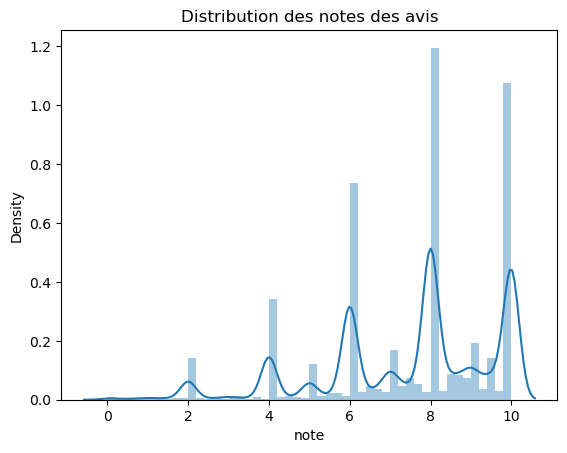

In [7]:
ax = sns.distplot(df_avis["note"])
ax.set_title("Distribution des notes des avis")

Distribution par utilisateur


Text(0.5, 0, 'Note par utilisateur')

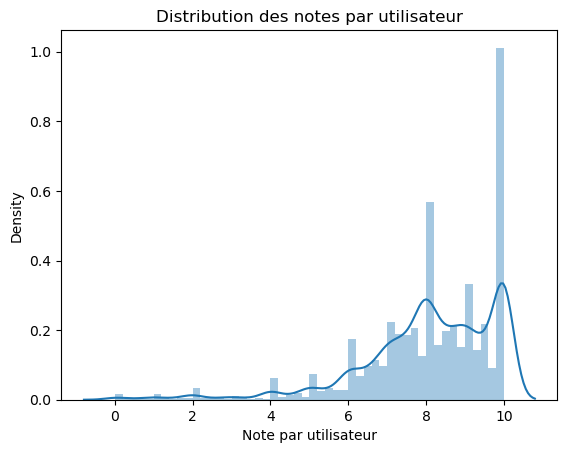

In [8]:
user_means = df_avis.groupby("author")["note"].mean()
ax = sns.distplot(user_means)
ax.set_title("Distribution des notes par utilisateur")
ax.set_xlabel("Note par utilisateur")

Distribution par jeu


Text(0.5, 0, 'Note par jeu')

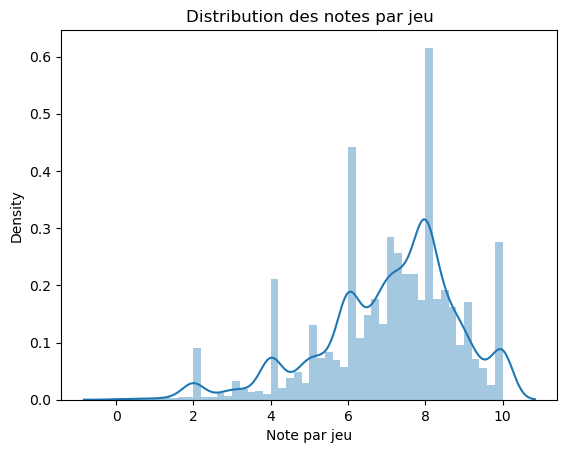

In [9]:
item_means = df_avis.groupby("title")["note"].mean()
ax = sns.distplot(item_means)
ax.set_title("Distribution des notes par jeu")
ax.set_xlabel("Note par jeu")

Vérification que chaque author n'a donné qu'un seul avis pour un jeu donné :


In [10]:
for i in df_avis.groupby(["author", "title"]):
    if len(i[1]) > 1:
        print("Duplicated author and title")
        df_avis_unique = traitement_reco.delete_dup(df_avis)
        break

Duplicated author and title


In [11]:
print("Nombre d'avis dupliqués : ", len(df_avis) - len(df_avis_unique))

Nombre d'avis dupliqués :  172


In [12]:
def describe_df(df):
    print(f"Nombre d'avis : {len(df)}")
    print(f"Nombre d'utilisateurs : {len(df['author'].unique())}")
    print(f"Nombre de jeux : {len(df['title'].unique())}")

    print("\n====================================================\n")

    _, count = np.unique(df["author"], return_counts=True)
    plt.plot(count[count.argsort()])
    plt.title("Répartition des avis par utilisateur")
    plt.xlabel("Utilisateurs")
    plt.ylabel("Nombre d'avis")
    plt.show()

    print("Mean =", np.mean(count))
    print("25th percentile =", np.quantile(count, 0.25))
    print("50th percentile =", np.quantile(count, 0.5))
    print("75th percentile =", np.quantile(count, 0.75))
    print("Minimum =", np.min(count))
    print("Maximum =", np.max(count))
    print("Standard Deviation =", np.std(count))

    print("\n====================================================\n")

    _, count = np.unique(df["title"], return_counts=True)
    plt.plot(count[count.argsort()])
    plt.title("Répartition des avis par jeu")
    plt.xlabel("Jeux")
    plt.ylabel("Nombre d'avis")
    plt.show()

    print("Mean =", np.mean(count))
    print("25th percentile =", np.quantile(count, 0.25))
    print("50th percentile =", np.quantile(count, 0.5))
    print("75th percentile =", np.quantile(count, 0.75))
    print("Minimum =", np.min(count))
    print("Maximum =", np.max(count))
    print("Standard Deviation =", np.std(count))

Nombre d'avis : 176071
Nombre d'utilisateurs : 13623
Nombre de jeux : 10709




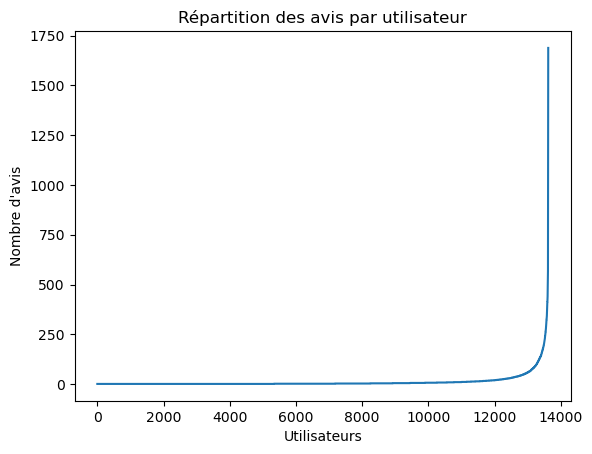

Mean = 12.924539381927623
25th percentile = 1.0
50th percentile = 2.0
75th percentile = 7.0
Minimum = 1
Maximum = 1688
Standard Deviation = 46.04849566072456




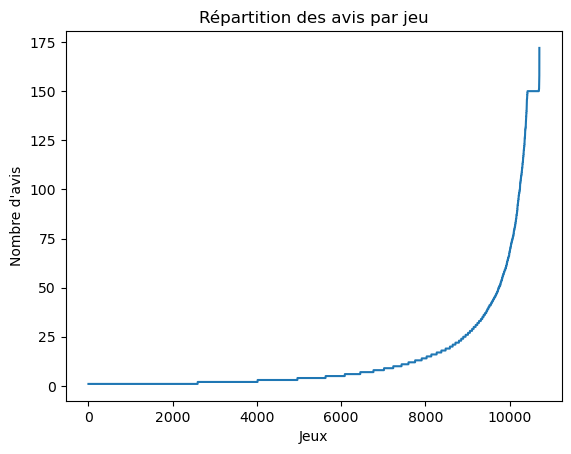

Mean = 16.441404426183585
25th percentile = 2.0
50th percentile = 4.0
75th percentile = 15.0
Minimum = 1
Maximum = 172
Standard Deviation = 31.03411212740304


In [13]:
describe_df(df_avis_unique)

## Collaborative filtering


### Demarrage à froid


On supprime les utilisateurs qui ont commenté moins de 8 fois, et les jeux avec moins de 8 avis ainsi jusqu'à convergence


In [14]:
nb_avis_min = 8

u, df_avis_filter = traitement_reco.clean_user(df_avis_unique, nb_avis_min=nb_avis_min)
g, df_avis_filter = traitement_reco.clean_game(df_avis_filter, nb_avis_min=nb_avis_min)
while u != 0 and g != 0:
    u, df_avis_filter = traitement_reco.clean_user(
        df_avis_filter, nb_avis_min=nb_avis_min)
    
    g, df_avis_filter = traitement_reco.clean_game(
        df_avis_filter, nb_avis_min=nb_avis_min)

In [15]:
game = np.unique(df_avis_unique["title"])
users = np.unique(df_avis_unique["author"])

game_filtred = np.unique(df_avis_filter["title"])
users_filtred = np.unique(df_avis_filter["author"])

print(
    "On a eliminé",
    100 * (len(users) - len(users_filtred)) / len(users),
    "% des utilisateurs",
)

print("On a eliminé", 100 * (len(game) - len(game_filtred)) / len(game), "% des jeux")

print(
    "On a eliminé",
    100 * (len(df_avis_unique) - len(df_avis_filter)) / len(df_avis_unique),
    "% des avis",
)

On a eliminé 77.17096087499083 % des utilisateurs
On a eliminé 66.35540199831917 % des jeux
On a eliminé 23.74212675568379 % des avis


Nombre d'avis : 134268
Nombre d'utilisateurs : 3110
Nombre de jeux : 3603




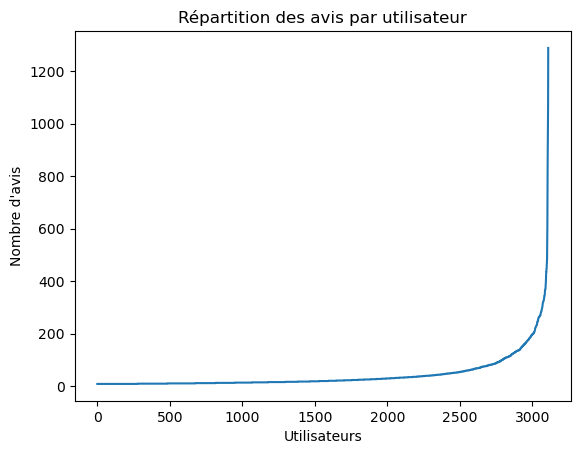

Mean = 43.17299035369775
25th percentile = 11.0
50th percentile = 19.0
75th percentile = 42.0
Minimum = 8
Maximum = 1289
Standard Deviation = 73.00046013859675




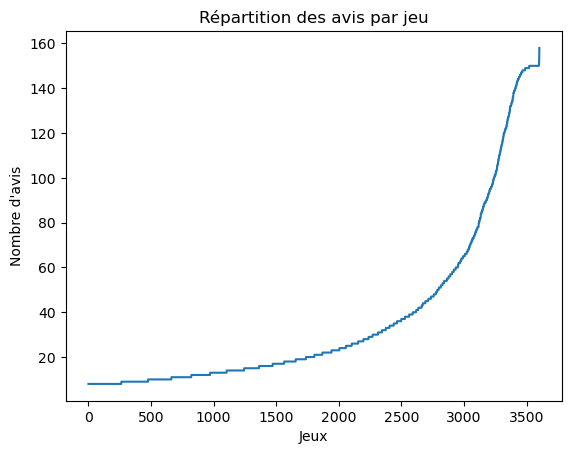

Mean = 37.265611990008324
25th percentile = 12.0
50th percentile = 20.0
75th percentile = 45.0
Minimum = 8
Maximum = 158
Standard Deviation = 38.495177090945695


In [16]:
describe_df(df_avis_filter)

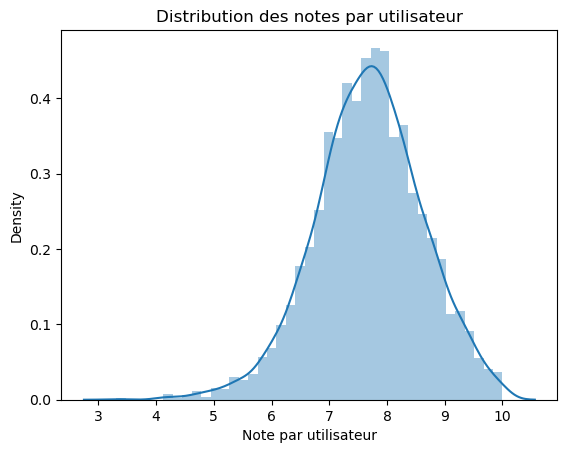

In [17]:
g_users = df_avis_filter.groupby("author")["note"].mean()
ax = sns.distplot(g_users[users_filtred])
ax.set_title("Distribution des notes par utilisateur")
ax.set_xlabel("Note par utilisateur")
plt.show()

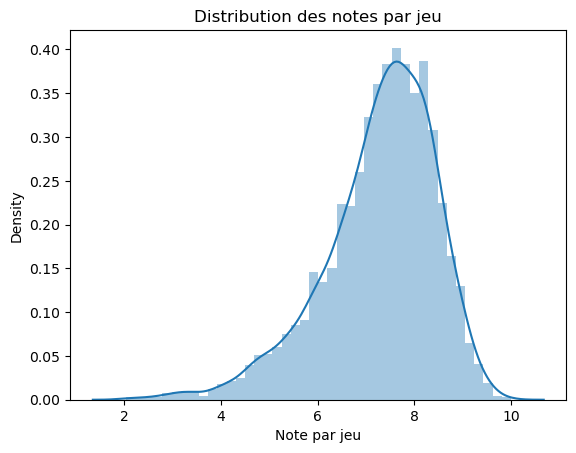

In [18]:
g_game = df_avis_filter.groupby("title")["note"].mean()
ax = sns.distplot(g_game[game_filtred])
ax.set_title("Distribution des notes par jeu")
ax.set_xlabel("Note par jeu")
plt.show()

In [19]:
train_ratings, test_ratings = train_test_split(df_avis_filter, test_size=0.2)

In [20]:
data = Dataset.load_from_df(train_ratings, Reader(rating_scale=(0, 10)))
data_test = Dataset.load_from_df(test_ratings, Reader(rating_scale=(0, 10)))

In [21]:
already_play = train_ratings.groupby("author")["title"].apply(list).to_dict()

ground_truth = (
    test_ratings[test_ratings.note >= 8]
    .groupby("author")["title"]
    .apply(list)
    .to_dict()
)

existing_games = set(train_ratings["title"].unique())

In [22]:
# test_users = list(ground_truth.keys())
# np.array(test_users)[np.array(list(map(lambda x: x in already_play.keys(), test_users))) == False]

In [23]:
dict_data = {
    "already_play": already_play,
    "ground_truth": ground_truth,
    "existing_games": existing_games,
    "data": data,
}

### Baseline algorithm


`reg_i` represent $\lambda_2$ : 

<img src="img/lambda2.png" />

`reg_u` represent $\lambda_3$ : 

<img src="img/lambda3.png" />

{'bsl_options': {'method': 'als', 'reg_u': 6, 'reg_i': 3}, 'verbose': False}


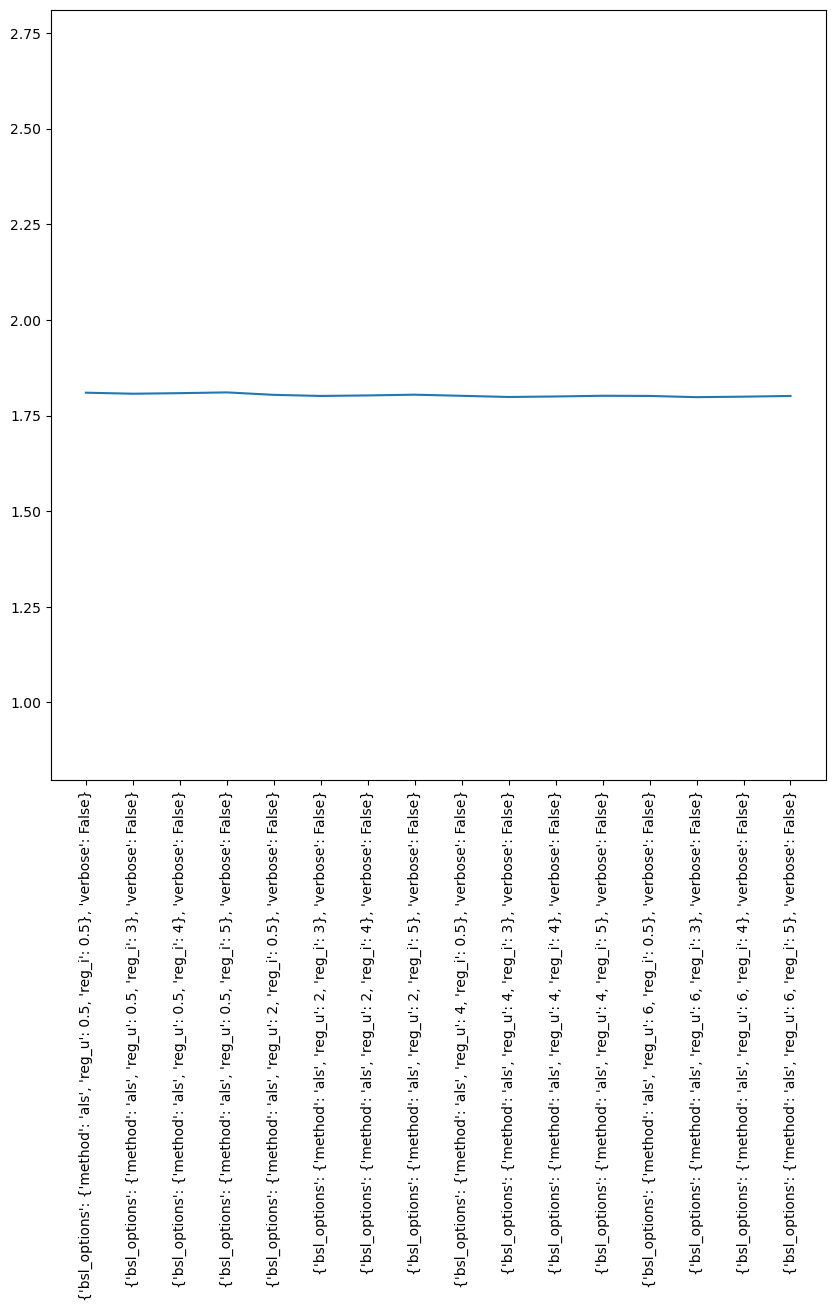

100%|██████████| 2740/2740 [00:23<00:00, 116.26it/s]


MRR : 0.016555858125964888
Rang du jeu : 60.401580660544546


In [24]:
bsl_options = {
    "method": ["als"],
    "reg_u": [0.5, 2, 4, 6],
    "reg_i": [0.5, 3, 4, 5],
}

param_grid = {"bsl_options": bsl_options, "verbose": [False]}

bs = prediction.gs_pred(dict_data, BaselineOnly, param_grid)

### SVD algorithm


Pour décider dans quel intervalle nous allons faire varier n_factors, nous avons calculé : 

(nombre d'utilisateurs + nombre de jeux) * n_factors <= len(data)


In [25]:
Z = len(df_avis_filter)/(len(game_filtred) + len(users_filtred))
print(f"On trouve n_factors max = {Z}")

On trouve n_factors max = 20.00119171756294


Donc si on fait varier les paramètres de régularisation on peut faire monter Z jusqu'à 40 environ

{'n_factors': 3, 'reg_all': 0.1}


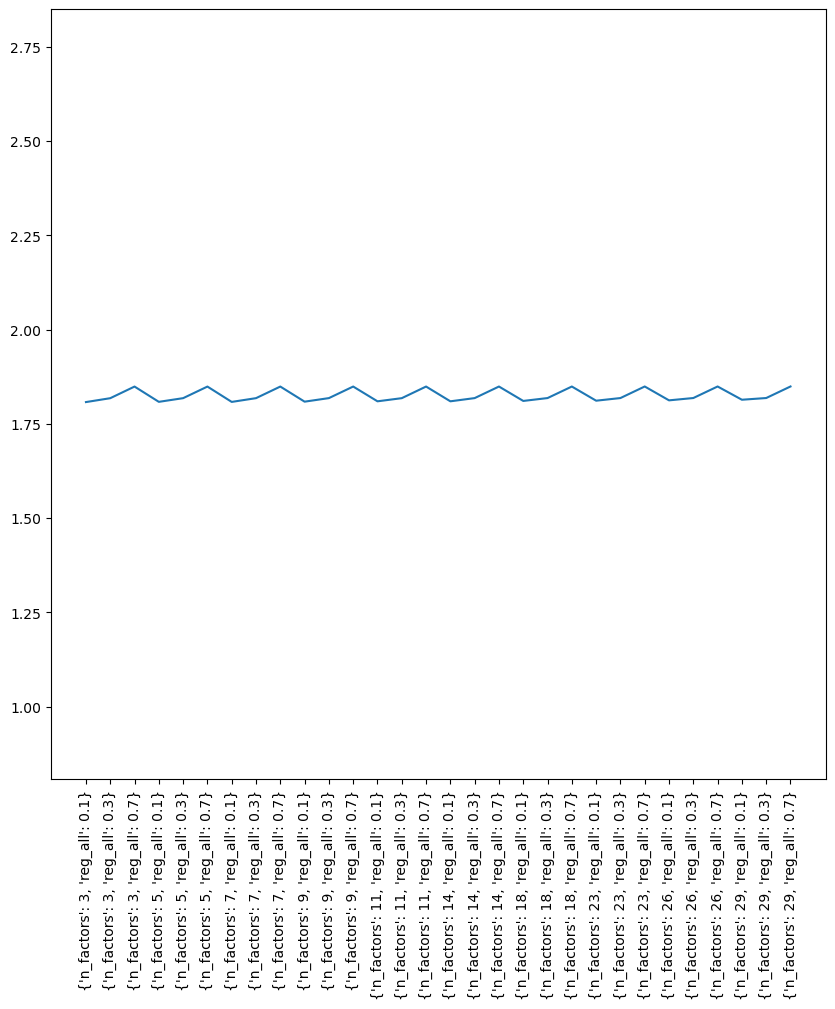

100%|██████████| 2740/2740 [00:39<00:00, 68.52it/s]


MRR : 0.021151326467634794
Rang du jeu : 47.278358713349434


In [26]:
param_grid = {
    "n_factors": [3,5,7,9,11,14,18,23,26,29],
    "reg_all": [0.1, 0.3, 0.7],
}

svd = prediction.gs_pred(dict_data, SVD, param_grid)

### KNN Basic


{'k': 29, 'verbose': False, 'sim_options': {'name': 'pearson', 'user_based': True}}


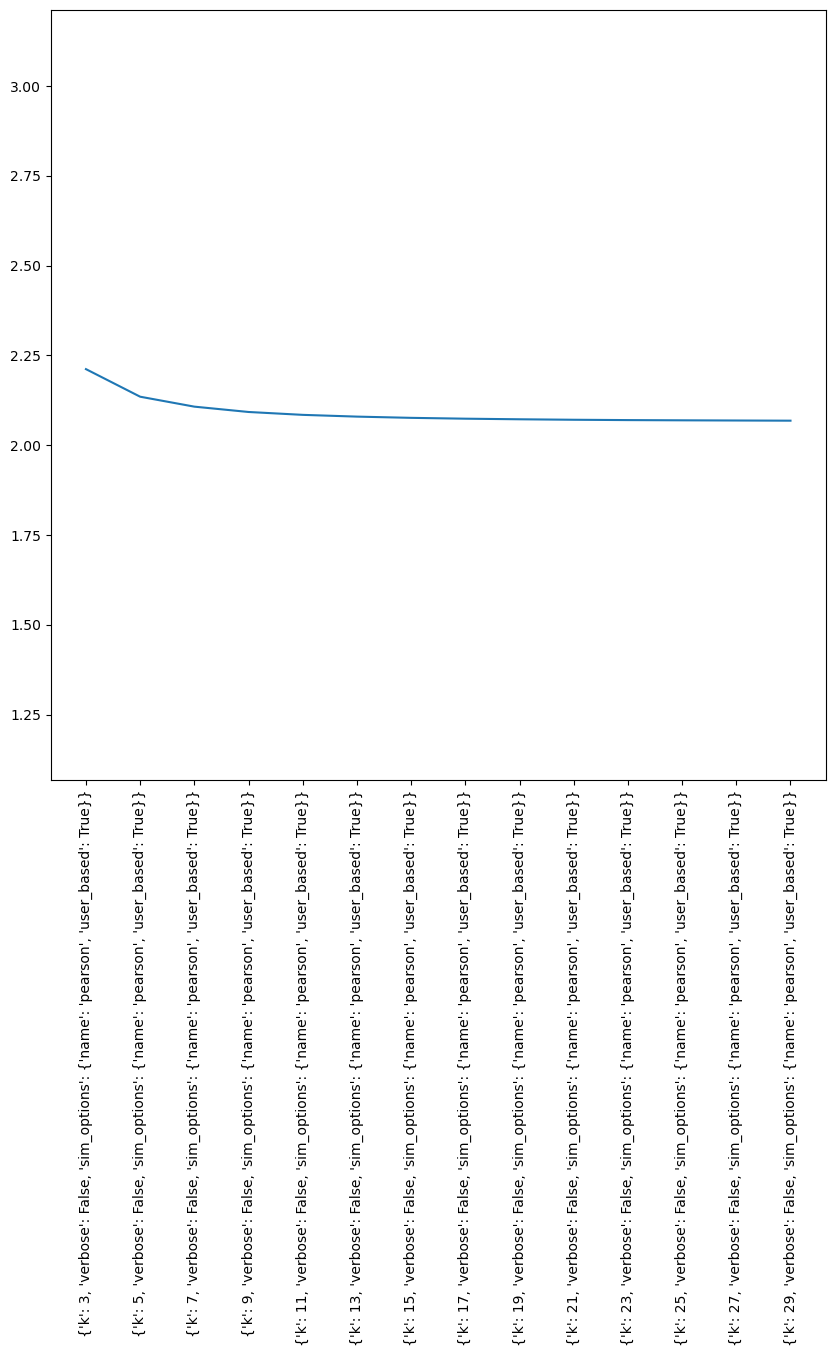

100%|██████████| 2740/2740 [03:07<00:00, 14.64it/s]


MRR : 0.007537179930549988
Rang du jeu : 132.67561730173927


In [27]:
sim_options = {
    "name": ["pearson"],
    "user_based": [True],
}

param_grid = {
    "k": list(range(3, 30, 2)),
    "verbose": [False],
    "sim_options": sim_options,
}

knn = prediction.gs_pred(dict_data, KNNBasic, param_grid)

### SVD ++

{'n_factors': 3, 'reg_all': 0.1}


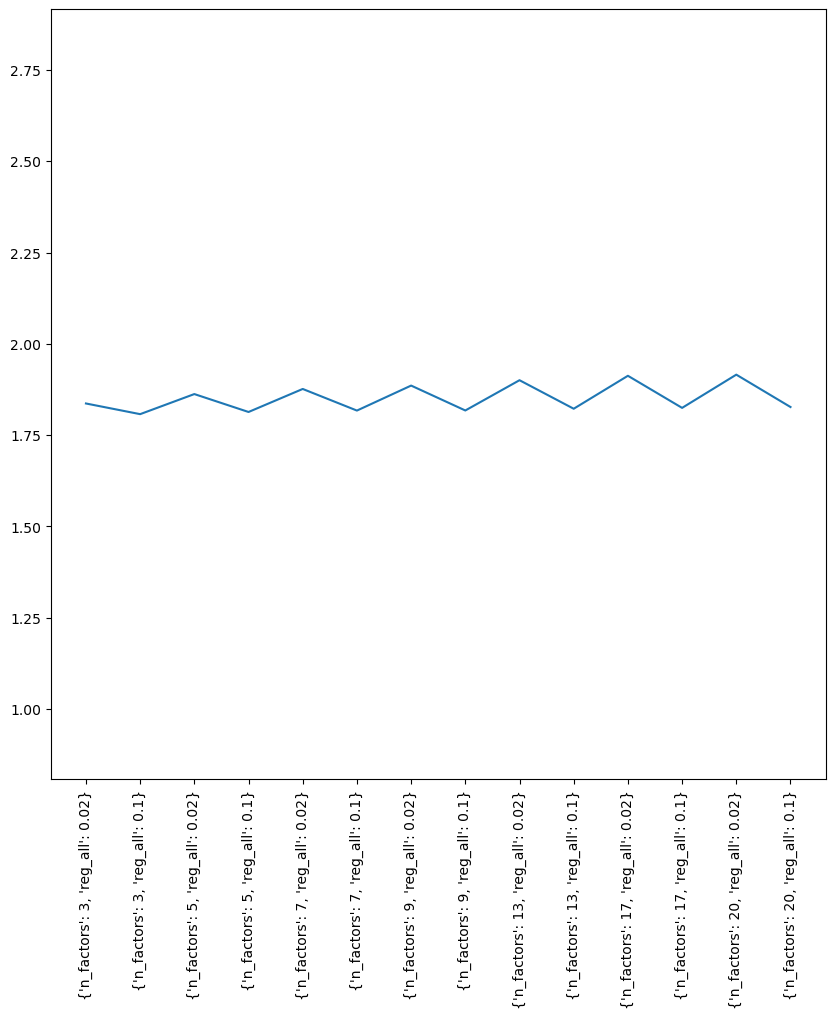

 18%|█▊        | 500/2740 [01:01<03:40, 10.15it/s]

In [28]:
param_grid = {
    "n_factors": [3,5,7,9,13,17,20],
    "reg_all": [0.02, 0.1],
}

svdpp = prediction.gs_pred(dict_data, SVDpp, param_grid)

### SlopeOne

In [ ]:
param_grid = {
}

slopeone = prediction.gs_pred(dict_data, SlopeOne, param_grid, plot=False)

{}


100%|██████████| 2727/2727 [02:20<00:00, 19.39it/s]


MRR : 0.005595973419364922


### NMF

{'n_factors': 48, 'reg_pu': 0.1, 'reg_qi': 0.5}


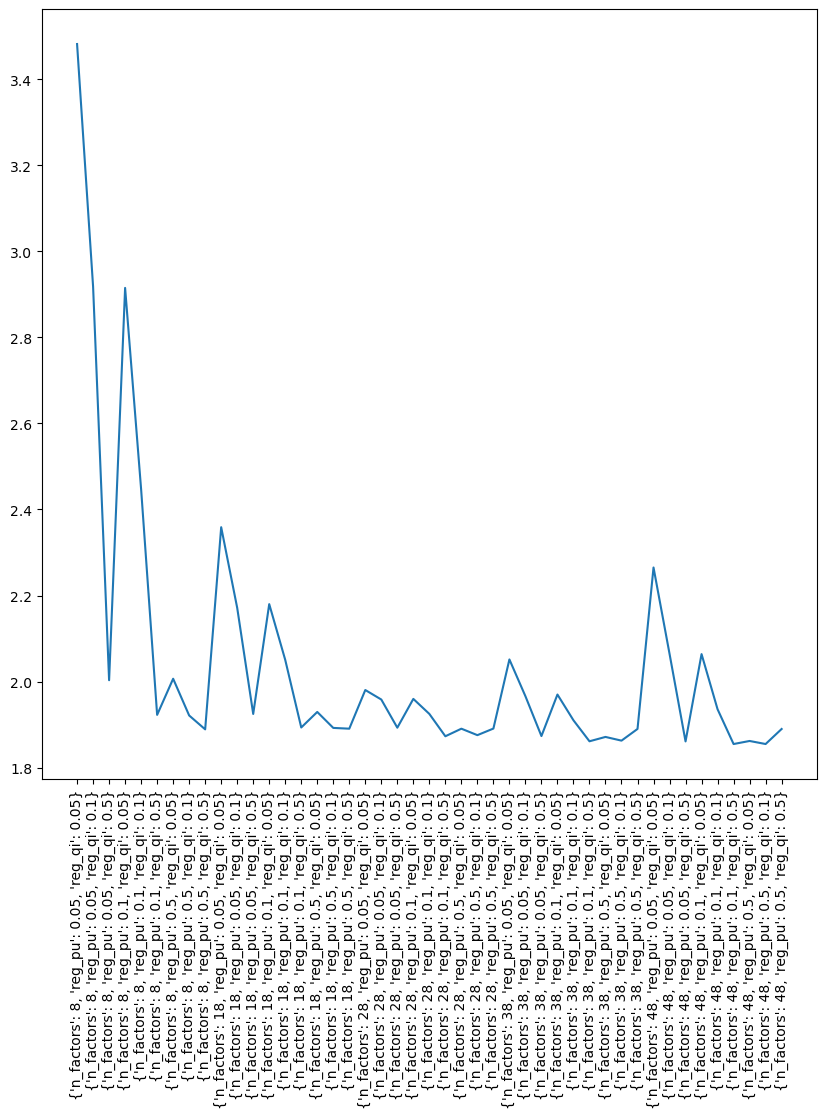

100%|██████████| 2727/2727 [00:33<00:00, 80.40it/s]


MRR : 0.011906063534951402


In [ ]:
param_grid = {
    "n_factors": [3,5,7,9,11,14,18,23,26,29],
    "reg_pu": [0.05, 0.1, 0.5],
    "reg_qi": [0.05, 0.1, 0.5],
}

nmf = prediction.gs_pred(dict_data, NMF, param_grid)

In [ ]:
models = [nmf, slopeone, knn, svd, svdpp, bs]

In [ ]:
results_mrr = {}
results_ndcg = {}

for model in models:
    predictions = prediction.get_user_predictions(model, dict_data)
    results_mrr[model.__class__.__name__] = prediction.mrr(predictions)
    results_ndcg[model.__class__.__name__] = prediction.ndcg_at_k(predictions)

100%|██████████| 2727/2727 [00:23<00:00, 116.02it/s]


Best Model au sens de la MRR : 

In [ ]:
model_opt_mrr = max(results_mrr, key=results_mrr.get)
print("Le model qui maximise la mrr est :", model_opt_mrr, "avec une valeur de", results_mrr[model_opt_mrr])

Le model qui maximise la mrr est : SVDpp avec une valeur de 0.018961566489619837


Best Model au sens de la NDCG : 

In [ ]:
model_opt_ndcg = max(results_ndcg, key=results_ndcg.get)
print("Le model qui maximise la ndcg est :", model_opt_ndcg, "avec une valeur de", results_ndcg[model_opt_ndcg])

Le model qui maximise la ndcg est : NMF avec une valeur de 1.0


### Bayesian Personalized Ranking

In [ ]:
dataset = LFMDataset()
dataset.fit((x for x in df_avis["author"]),
            (x for x in df_avis['title']))

(train_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in train_ratings.itertuples())
)
    
(test_interactions, weights) = dataset.build_interactions(
    ((x.author, x.title) for x in test_ratings.itertuples())
)

In [ ]:
bpr = LightFM(loss='bpr')
bpr.fit(train_interactions)

In [ ]:
bpr_mrr = reciprocal_rank(bpr, test_interactions, train_interactions).mean()

In [ ]:
bpr_mrr

0.033003826

## Création d'un systeme de recommandation pour un utilisateur :

In [ ]:
def basic_recommand_games(model, user, games, df, nb_games=3):
    scores = []
    
    user_games = list(df[df["author"] == user]["title"])
    
    for game in games:
        
        if game in user_games:
            scores.append(0)
            continue
        
        prediction = model.predict(user, game)
        scores.append(prediction.est)
    
    scores = np.array(scores)
    i_sort = np.argsort(-scores)
    return games[i_sort[:nb_games]]

In [ ]:
df_avis_filter[df_avis_filter["author"] == "§Gama§"]

,author,title,note
109250,§Gama§,Ad' Astra,8.0
68944,§Gama§,Archipelago,2.0
142924,§Gama§,Attacktix,4.0
153727,§Gama§,Crimson Skies CMG,8.0
99583,§Gama§,César et Cléopâtre,10.0
173667,§Gama§,Draco & Co,8.0
115912,§Gama§,Elfenland,8.0
170665,§Gama§,Hanafuda,2.0
114452,§Gama§,Illuminati,8.0
155690,§Gama§,L'Escalier Hanté,4.0


In [ ]:
nmf_games = basic_recommand_games(nmf, '§Gama§', games, df_avis, nb_games=20)
nmf_games

array(['Twilight Imperium : Shattered Empire', 'Cast News', 'Dream On!',
       'Le Seigneur des Anneaux CCG - Les Sorciers', 'Wiz-War',
       'Le Tyran du Désert', 'Magna Grecia',
       'T.I.M.E Stories - Estrella Drive',
       "La Guerre de l'Anneau : Les Batailles du Tiers Âge",
       'La Créature venue du Chaos', 'Nieuw Amsterdam',
       'Ursuppe : Frisch Abgeschmeckt', 'Ascending Empires',
       'Ghost Stories : White Moon', '2 sans 3',
       'Age of Steam Expansion #1: England & Ireland',
       'Starcraft : Brood War', 'Tokyo Highway (version européenne)',
       'Legendary: Dark City', 'The Great Zimbabwe'], dtype=object)

In [ ]:
svdpp_games = basic_recommand_games(svdpp, '§Gama§', games, df_avis, nb_games=20)
svdpp_games

array(['Twilight Struggle', "Horreur à Arkham : L'Horreur de Dunwich",
       'Ghost Stories : The Guardhouse', 'Magna Grecia',
       'Les Dames de Troyes', 'Cyclades :  Hades', 'Root',
       'Rallyman : Dirt', 'Tales of Arabian nights',
       "Endeavor : L'âge de la voile (VF)", 'Maharaja',
       'Mare Nostrum : extension mythologique',
       "L'Œil Noir - Initiation au jeu d'Aventure", 'Rush Hour',
       'Terraforming Mars', 'Imperial', 'Trickerion: Legends of Illusion',
       "À la gloire d'Odin", 'Roads & Boats',
       'Sekigahara: Unification of Japan'], dtype=object)

In [ ]:
common_elements = np.intersect1d(nmf_games, svdpp_games)
similarity_percent = len(common_elements) / len(np.union1d(nmf_games, svdpp_games)) * 100
print(f"Pourcentage de similarité entre la reco de NMF et SVDpp: {similarity_percent:.2f}%")

Pourcentage de similarité entre la reco de NMF et SVDpp: 2.56%


# Visualisation t-SNE

In [ ]:
SVDmodel = SVD(n_factors=5, reg_all=0.1)
SVDmodel.fit(dict_data["data"].build_full_trainset())

In [ ]:
vectors_test = SVDmodel.qi

df_test = pd.DataFrame(vectors_test)

df_test.to_csv('t-sne.tsv', sep='\t', index=False)